In [ ]:
%load_ext autoreload

In [ ]:
# !pip install wandb
# import wandb

%autoreload 2
import torch
import torch.nn as nn
import torch.utils.data as Data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Our fancy new modules
from subgrid_parameterization.arch import ANN
from subgrid_parameterization.preprocess.torch_helpers import split_dataset
import subgrid_parameterization.util.plot_helpers as plot_helpers
import subgrid_parameterization.preprocess.saminterface as sam
from subgrid_parameterization.train import Trainer

import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [ ]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

path = "sam-rf02/"
file = "DYCOMS_RF02_128x128x96_dr_nosed"
# file = '*_3d'
save = "C14_DYCOMS2"

ds = xr.open_dataset(path0 + path + file + ".nc")

In [ ]:
# Create a CLUBB momentum grid and the dataset
z_sam = np.asarray(ds["z"], dtype=np.float64)
nzm = (len(z_sam) + 1) // 2
zm = np.concatenate(
    ([0], 0.5 * (z_sam[1 : 2 * nzm - 1 : 2] + z_sam[2 : 2 * nzm - 1 : 2]))
)
grids = sam.CLUBBGrids.from_momentum_grid(zm)
sam_ds = sam.SAMDataInterface(ds, grids)

ngrdcol = len(ds["time"])
nzt = len(grids.zt)

In [ ]:
L, Lup, Ldown = sam_ds.get_mixing_length()

In [ ]:
Hscale = 1000  # 1km to normalize mixing lengths which are bounded by  ~40 m and ~3km

In [ ]:
C14 = sam_ds.get_C14()

In [ ]:
up2 = sam_ds.get_sam_variable_on_clubb_grid("U2", "zt")
vp2 = sam_ds.get_sam_variable_on_clubb_grid("V2", "zt")
wp2 = sam_ds.get_sam_variable_on_clubb_grid("W2", "zt")
e = 0.5 * (up2 + vp2 + wp2)

In [ ]:
disp = sam_ds.get_disp()

In [ ]:
C14min = 0.2
C14max = 2
minMask = disp < -2 / 3 * C14min / L * e**1.5
maxMask = e > (-1.5 * disp * L / C14max) ** (2 / 3)
# maxMask = e[minMask] >  (-1.5*disp[minMask]*L[minMask]/C14max)**(2/3)

/glade/derecho/scratch/adac/tmp/ipykernel_44227/1375565756.py:4: RuntimeWarning: invalid value encountered in power
  maxMask = e > (-1.5 * disp * L / C14max) ** (2 / 3)


In [ ]:
input = list()
output = list()
for it in range(ngrdcol):
    for k in range(nzt):
        if minMask[it, k] and maxMask[it, k]:
            input.append(
                [
                    up2[it, k] / e[it, k],
                    vp2[it, k] / e[it, k],
                    wp2[it, k] / e[it, k],
                    Lup[it, k] / Hscale,
                    Ldown[it, k] / Hscale,
                ]
            )
            output.append([C14[it, k]])
print(str(len(input)) + " samples")

10461 samples


In [ ]:
dycoms_dataset = Data.TensorDataset(torch.tensor(input), torch.tensor(output))

In [ ]:
train_dataset, test_dataset = split_dataset(
    dycoms_dataset, 0.2
)  # random_split(bomex_dataset,[0.8,0.2]) returns a Subset so doesn't work later

In [ ]:
_, C14train = train_dataset.tensors
# np.array([numerator/(np.std(np.array(output)[:,i])) for i in range(np.array(output).shape[1])])
lossweights = np.ones(C14train.detach().numpy().shape[1])

In [ ]:
config = {
    "batch_size": 360,
    "lr": 0.001,  ## learning rate
    "wd": 0.01,  ## weight decay
    "epochs": 2000,  ## Setting this to a high number because early stopping
    # "subsample":10,   ## Take a subsample of 1000 data points
    "patience": 20,  ## Patience for early stopping
}

beta1 = 0.5
beta2 = 0.999

In [ ]:
# use GPUs if available
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device("cuda")
else:
    print("CUDA Not Available")
    device = torch.device("cpu")

CUDA Not Available


In [ ]:
## Construct training and validation dataloaders
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=True)

## Record number of training/validation images
# config["training_fields"]=len(pyqg_dataset.test_idx)
# config["validation_fields"]=len(pyqg_dataset.valid_idx)

In [ ]:
nvars = 5  # ups,vp2,wp2,Lup,Ldown
iso = True
if iso:
    nvarsout = 1
else:
    nvarsout = 2

N = [nvars, 16, 8, nvarsout]

try:
    del model
    model = ANN(N).double()  ## NN architecture: could be FCNN, resnet, ANN.. etc
except:
    model = ANN(N).double()  ## NN architecture: could be FCNN, resnet, ANN.. etc

model.to(device)
config["learnable parameters"] = sum(p.numel() for p in model.parameters())

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["lr"],
)  # weight_decay=config["wd"], betas=(beta1, beta2))
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=10)
criterion = nn.MSELoss()

In [ ]:
# wandb.init(project="wandb_demo", entity="m2lines",config=config)
# wandb.watch(model, log_freq=1)

In [ ]:
trainer = Trainer(config=config, device=device, lossweights=lossweights)

best_model = trainer.train_loop(
    model, optimizer, train_loader, valid_loader, save_name=save
)

Early stopping epoch: 500


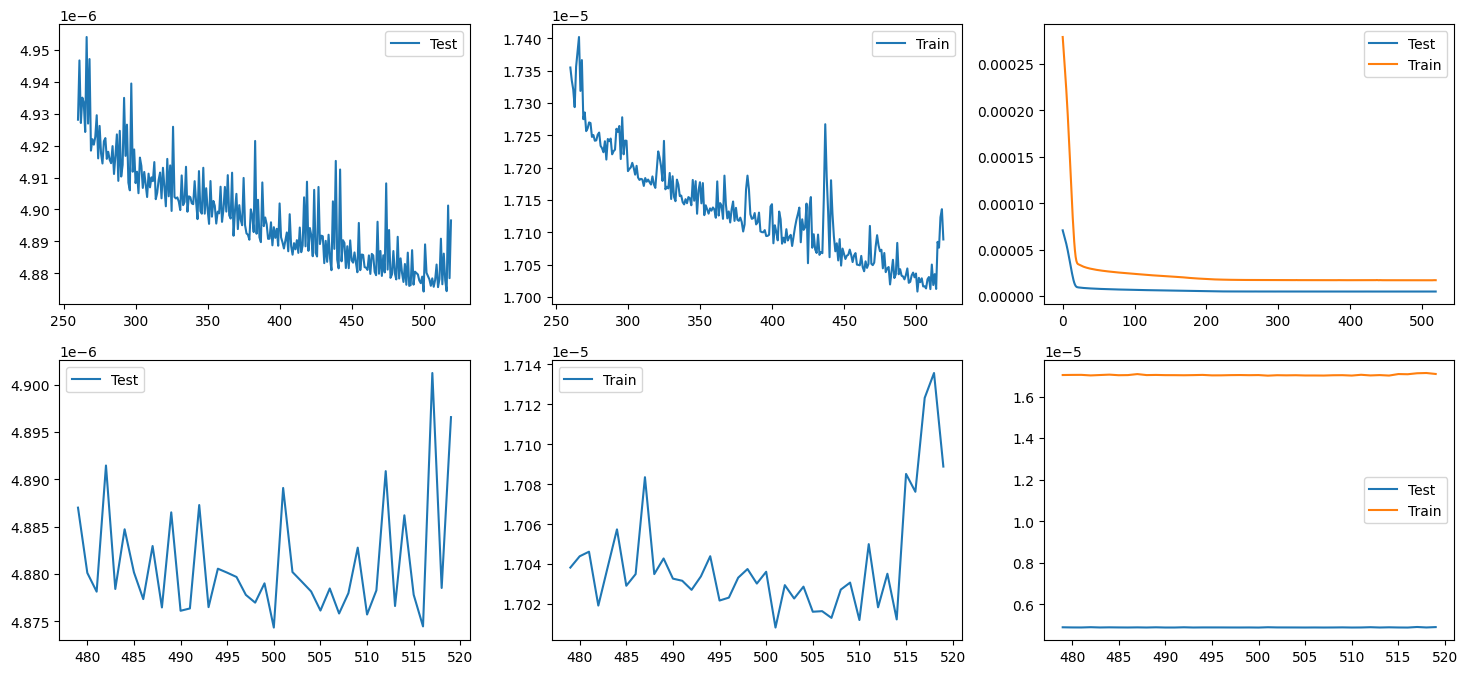

In [ ]:
cutStartPct = 0.5
zoomEndEpochs = 2 * config["patience"]
plot_helpers.plot_losses(
    [trainer.test_loss, trainer.train_loss],
    ["Test", "Train"],
    cutStartPct,
    zoomEndEpochs,
)

In [ ]:
x_test, y_test = test_dataset.tensors
# x_test=x_test.to(device)
y_test = y_test.squeeze().detach().cpu().numpy()
y_pred = best_model(x_test).squeeze().detach().cpu().numpy()

In [ ]:
y_text = r"$C_{14}$"
# r2=np.empty(nzt)
# r=np.empty(nzt)
# for k in range(nzt):
#     r2[k]=r2_score(y_test[:,k], y_pred[:,k])
#     r[k]=np.corrcoef(y_test[:,k], y_pred[:,k])[0, 1]
r2 = r2_score(y_test, y_pred)
r = np.corrcoef(y_test, y_pred)[0, 1]

print("Statistics for " + y_text)
print("R^2: %.4f" % np.mean(r2))
print("Correlation: %.4f" % +np.mean(r) + "\n")

Statistics for $C_{14}$
R^2: 0.4470
Correlation: 0.6686



Text(0.5, 1.0, '$C_{14}$')

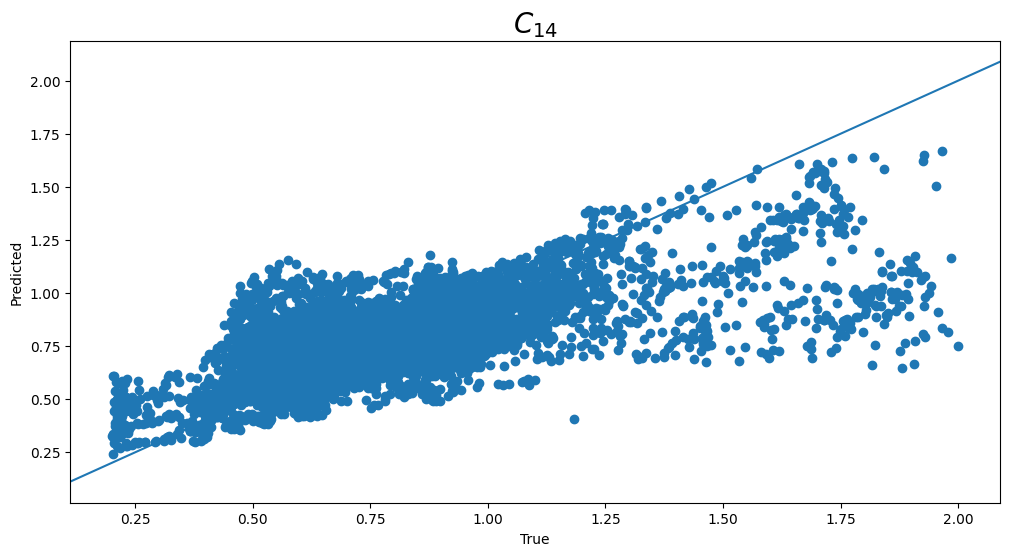

In [ ]:
l1 = "Predicted"
l2 = "True"
nvar = 1
# z=zt[0,:]
y_text = r"$C_{14}$"

# fig1,ax1 = plt.subplots(1,nvar,figsize = (12, 6))
fig2, ax2 = plt.subplots(1, nvar, figsize=(12, 6))
# fig3,ax3 = plt.subplots(1,nvar,figsize = (12, 6))

ax2.scatter(y_test, y_pred)
xmin, xmax = ax2.get_xlim()
ymin, ymax = ax2.get_ylim()
ax2.plot([xmin, xmax], [xmin, xmax])
ax2.set_xlim([xmin, xmax])
# ax2.set_xlim([0, 2])
# ax2.set_ylim([0, 1])
ax2.set_xlabel(l2)
ax2.set_ylabel(l1)
ax2.set_title(y_text, fontsize=20)

In [ ]:
# ax1.plot(r2,z,'b',linewidth=2)
# ax1.set_title(y_text,fontsize=20)
# ax1.set_xlabel(r'R$^2$',fontsize=20)
# ax1.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# print("Avg. across all levels for "+y_text)
# print("R^2: %.4f" % np.mean(r2) )
# print("Correlation: %.4f" % +np.mean(r)+"\n")

# for it in range(y_pred.shape[0]):
#     ax3.plot(y_pred[it],z,'r',label=l1)
#     ax3.plot(y_test[it],z,'k',label=l2)
#     l1,l2='__nolegend__','__nolegend__'
#     ax3.set_xlabel(y_text,fontsize=20)
#     ax3.set_ylabel(r'$z$',rotation=0,fontsize=20)

# # ax3.set_ylabel(r'$\frac{z}{z_{\text{top}}}$',rotation=0,fontsize=20)
# ax3[0].legend()
# l1='Predicted'
# l2='True'

In [ ]:
# y_text=[r"$\overline{u'w'}/u_*^2$",r"$\overline{v'w'}/u_*^2$"]
# y_text=["U2DFSN","V2DFSN"]
# y_text[r'C_{14}']
# fig1,fig2,fig3=quickPlots(best_model,test_dataset,y_text,device)

In [ ]:
# best_model.to("cpu")
# figure_fields=wandb.Image(plot_helpers.plot_fields(pyqg_dataset,best_model))
# wandb.log({"Fields": figure_fields})

In [ ]:
# r2_upper,r2_lower,figure_power=metrics.get_offline_metrics(best_model,valid_loader)
# figure_power=wandb.Image(figure_power)
# wandb.log({"Power spectrum": figure_power})

In [ ]:
# wandb.run.summary["r2_upper"]=r2_upper
# wandb.run.summary["r2_lower"]=r2_lower
# wandb.finish()